In [28]:
%%capture
!gdown --fuzzy -O data.csv https://drive.google.com/file/d/1fvKO9isQzaN0dUuLnWc3MOhFzctVvXz3/view?usp=sharing
!gdown --fuzzy -O nn.json https://drive.google.com/file/d/12_5iM4epl3bsxAtlrS7jHjmgZxzk6cIM/view?usp=sharing
!gdown --fuzzy -O model_main.cbm https://drive.google.com/file/d/1_asd6m35_GPqTl92nqKt5IKtp9JXCb3Z/view?usp=sharing
!wget https://raw.githubusercontent.com/d10xa/holidays-calendar/master/json/calendar.json

In [29]:
%%capture
!pip install catboost

In [39]:
import pandas as pd
import numpy as np
import datetime
import json
import numpy as np
from catboost import CatBoostRegressor, Pool

In [40]:
with open("nn.json") as f:
    stats = json.load(f)

to_df = {}
for year, d in stats.items():
    for month, value in d.items():
        for i in range(1, len(value['temp'])+1):
            new_key = str(year) + '/' + month + '/' + str(i)
            cur = {}
            for col in value.keys():
                cur.update({col: value[col][i-1]})
            to_df[new_key] = cur
weather = pd.DataFrame.from_dict(to_df, orient='index')
weather.index = [datetime.datetime.strptime(x, '%Y/%B/%d') for x in weather.index.values]
weather = weather.reset_index().rename({"index": "Дата"}, axis=1)

In [41]:
weather.head(2)

,Дата,temp,wet,p,wind
0,2020-01-01,-3.86,93.71,744,3
1,2020-01-02,-2.57,92.29,749,3


In [42]:
with open("calendar.json", "r") as f:
    nowork_days = json.load(f)

In [43]:
df = pd.read_csv('data.csv')

In [87]:
df.columns

Index(['Дата', 'year', 'month', 'day', 'Подстанция', 'quarter', 'dayofweek',
       'Диагноз_ Ангионевротический отек', 'Диагноз_ Пневмония неуточненная',
       'Диагноз_-',
       ...
       'Время в пути', 'age_type', 'holidays', 'preholidays', 'nowork',
       'Сезон', 'temp', 'wet', 'p', 'wind'],
      dtype='object', length=1467)

In [44]:
def prepare_dataframe(df):
    df['Дата'] = pd.to_datetime(df['Дата'])
    df['year'] = df['Дата'].apply(lambda x: x.year)
    df['month'] = df['Дата'].apply(lambda x: x.month)
    df['day'] = df['Дата'].apply(lambda x: x.day)
    df["quarter"] = df["Дата"].dt.quarter
    df["dayofweek"] = df["Дата"].dt.dayofweek

    df['age_type'] = df['Возраст'].apply(lambda x: 1 if "лет" in x else 0)
    df['Возраст'] = df['Возраст'].apply(lambda x: int(x.split()[0]) if x != '-' else 0)

    df['Принят'] = df['Принят'].astype(str).apply(lambda x: datetime.datetime.strptime(x, '%H:%M') if ':' in x else datetime.datetime.strptime('0:0', '%H:%M'))
    df['Приезд'] = df['Приезд'].astype(str).apply(lambda x: datetime.datetime.strptime(x, '%H:%M') if ':' in x else datetime.datetime.strptime('0:0', '%H:%M'))
    df['Время в пути'] = [((x - y).seconds//60)%60 for x, y in zip(df['Приезд'], df['Принят'])]

    agg_dict = {}
    for prefix in ['Диагноз', 'Результат', 'Повод', 'Доставлен', 'Кто вызвал', 'Вид']:
        sub_df = pd.get_dummies(df[prefix])
        sub_df.columns = [prefix + '_' + c for c in sub_df.columns]
        for c in sub_df.columns:
            agg_dict[c] = 'median'
        df = df.join(sub_df)
    
    agg_dict['Диагноз'] = ' '.join
    agg_dict['Результат'] = ' '.join
    agg_dict['Номер'] = 'count'
    agg_dict['Возраст'] = 'median'
    agg_dict['Время в пути'] = 'median'
    agg_dict['age_type'] = 'median'

    df.drop(columns=['Адрес', 'Повод', 'Доставлен', 'Принят',
                     'Кто вызвал', 'Вызов', 'Вид', 'Приезд'], inplace=True)
    
    df = df.fillna('')

    group_df = df.groupby(['Дата', 'year', 'month', 'day',
                       'Подстанция', 'quarter', 'dayofweek']).agg(agg_dict)

    group_df = group_df.reset_index()

    group_df["holidays"] = group_df["Дата"].isin(nowork_days["holidays"])
    group_df["preholidays"] = group_df["Дата"].isin(nowork_days["preholidays"])
    group_df["nowork"] = group_df["Дата"].isin(nowork_days["nowork"])

    group_df.rename(columns={'Номер': "Загруженность"}, inplace=True)
    target = group_df[["Дата", 'Загруженность']].copy()

    season_dict = {1: 'Зима', 2: 'Зима', 3: 'Весна', 4: 'Весна', 5: 'Весна',
                   6: 'Лето', 7: 'Лето', 8: 'Лето', 9: 'Осень', 10: 'Осень',
                   11: 'Осень', 12: 'Зима'}
    group_df = group_df[:-1]
    group_df['Сезон'] = group_df['month'].apply(lambda x: season_dict[x])

    group_df = group_df.merge(weather, on="Дата", how="left")

    group_df["quarter"] = group_df["quarter"].astype(np.int32)
    group_df["dayofweek"] = group_df["dayofweek"].astype(np.int32)

    return group_df.drop(['Диагноз', "Результат"], axis=1), target

In [45]:
df, target = prepare_dataframe(df)

In [46]:
train_data = Pool(df,
    cat_features=['Подстанция', 'Сезон',
                  'quarter', 'dayofweek']  
)

In [47]:
model = CatBoostRegressor(cat_features=['Подстанция', 'Сезон',
                                        'quarter', 'dayofweek'])
model = model.load_model("model_main.cbm")

In [57]:
train_data

In [63]:
df['Дата'] = df['Дата'].astype('object')

In [67]:
df.dtypes.value_counts()

uint8      999
float64    454
object       6
bool         3
int64        3
int32        2
dtype: int64

In [69]:
shap_values[0,:]

array([-5.24983351e+00, -1.30933077e-01, -7.34703657e-02, ...,
        8.31318142e-02, -5.15786826e-03,  0.00000000e+00])

In [70]:
explainer.expected_value

11.572965191788274

In [73]:
df['Дата'] = df['Дата'].apply(lambda x: str(x).split()[0])

In [74]:
df.iloc[0,:]

Дата          2020-01-01
year                2020
month                  1
day                    1
Подстанция       ПСМП №7
                 ...    
Сезон               Зима
temp               -3.86
wet                93.71
p                    744
wind                   3
Name: 0, Length: 1467, dtype: object

In [94]:
shap.force_plot(explainer.expected_value, shap_values[1,:], df.iloc[1,:])

In [96]:
shap_values.shape
df.shape

(14591, 1467)

(1467,)

In [101]:
shap.force_plot(explainer.expected_value, shap_values[2,:], df.iloc[2,:])

In [109]:
df.columns

Index(['Дата', 'year', 'month', 'day', 'Подстанция', 'quarter', 'dayofweek',
       'Диагноз_ Ангионевротический отек', 'Диагноз_ Пневмония неуточненная',
       'Диагноз_-',
       ...
       'Время в пути', 'age_type', 'holidays', 'preholidays', 'nowork',
       'Сезон', 'temp', 'wet', 'p', 'wind'],
      dtype='object', length=1467)

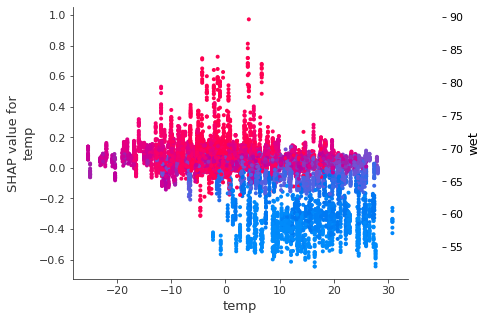

In [81]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, df)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


KeyboardInterrupt: 

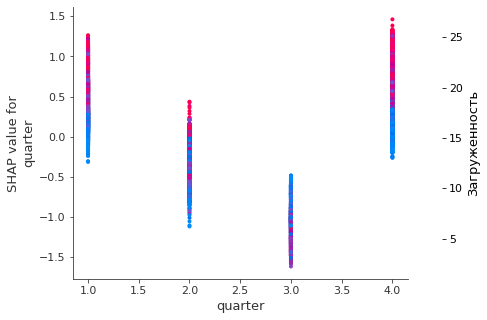

In [83]:
shap.dependence_plot("quarter", shap_values, df)

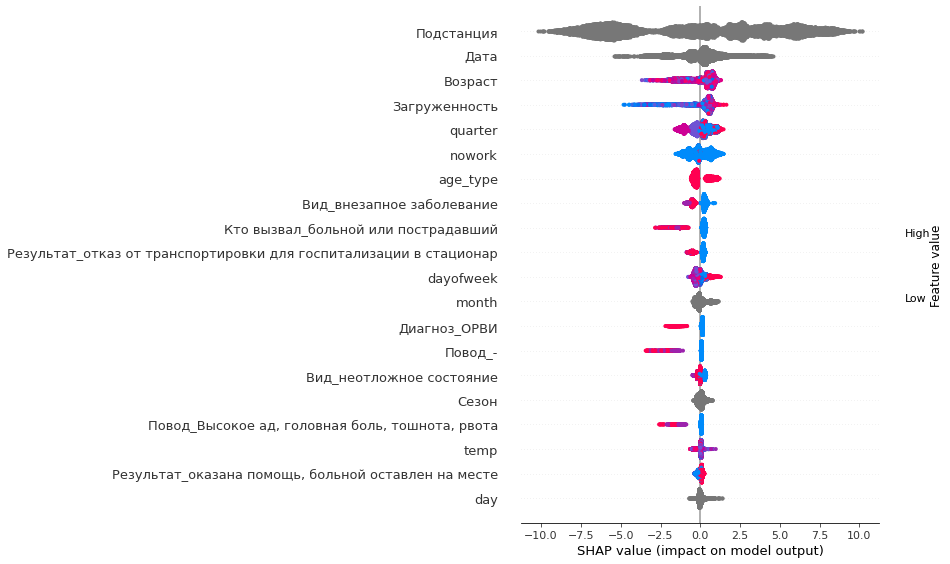

In [84]:
shap.summary_plot(shap_values, df)

In [93]:
df['nowork']

0        False
1        False
2        False
3        False
4        False
         ...  
14586    False
14587    False
14588    False
14589    False
14590    False
Name: nowork, Length: 14591, dtype: bool

In [89]:
model.get_feature_importance(prettified=True).to_csv('фичи.csv')

In [12]:
model.predict(train_data)

array([12.64459681, 14.10356095, 10.93181053, ...,  3.40636968,
        2.78312429,  2.55008121])